In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import save_history, save_model, plot_metrics, plot_visualizations

In [3]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
model_version = 'v12.0'

In [5]:
with open('../data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [6]:
df = pd.read_csv(f"../data/processed/spectrometry_photometry.csv")

X = df[spectro_cols + photo_cols + generic_cols]
y = df[target_col]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_value)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_32')(inputs)
x = layers.Activation('relu', name='Act_32')(x)
x = layers.Dropout(0.2, name='Dropout_32')(x)

# Layer 2
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(x)
x = layers.Activation('relu', name='Act_64')(x)
x = layers.Dropout(0.2, name='Dropout_64')(x)

# Layer 3
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Activation('relu', name='Act_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)

# Layer 4
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.Activation('relu', name='Act_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)

# Layer 5
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Activation('relu', name='Act_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)

# Layer 6
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_64_2')(x)
x = layers.Activation('relu', name='Act_64_2')(x)
x = layers.Dropout(0.2, name='Dropout_64_2')(x)

# Layer 7
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_32_2')(x)
x = layers.Activation('relu', name='Act_32_2')(x)
x = layers.Dropout(0.2, name='Dropout_32_2')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Regression_Model')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Use Huber loss to balance sensitivity to outliers
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.Huber(), 
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 58)]              0         
                                                                 
 Dense_32 (Dense)            (None, 64)                3776      
                                                                 
 Act_32 (Activation)         (None, 64)                0         
                                                                 
 Dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 Dense_64 (Dense)            (None, 64)                4160      
                                                                 
 Act_64 (Activation)         (None, 64)                0         
                                                                 
 Dropout_64 (Dropout)        (None, 64)           

In [10]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.5,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
2443/2443 [==============================] - 41s 16ms/step - loss: 0.7835 - mae: 0.7787 - mse: 1.8933 - mape: 7.4099 - val_loss: 0.1835 - val_mae: 0.1676 - val_mse: 0.0605 - val_mape: 1.6376
Epoch 2/200
2443/2443 [==============================] - 39s 16ms/step - loss: 0.2686 - mae: 0.5028 - mse: 0.4049 - mape: 4.7806 - val_loss: 0.0532 - val_mae: 0.1329 - val_mse: 0.0493 - val_mape: 1.3127
Epoch 3/200
2443/2443 [==============================] - 39s 16ms/step - loss: 0.1874 - mae: 0.4646 - mse: 0.3474 - mape: 4.4237 - val_loss: 0.0352 - val_mae: 0.1273 - val_mse: 0.0437 - val_mape: 1.2504
Epoch 4/200
2443/2443 [==============================] - 41s 17ms/step - loss: 0.1681 - mae: 0.4434 - mse: 0.3187 - mape: 4.2245 - val_loss: 0.0426 - val_mae: 0.1739 - val_mse: 0.0628 - val_mape: 1.6964
Epoch 5/200
2443/2443 [==============================] - 41s 17ms/step - loss: 0.1569 - mae: 0.4262 - mse: 0.2955 - mape: 4.0624 - val_loss: 0.0480 - val_mae: 0.1907 - val_mse: 0.0736 - va

In [22]:
model.save(f'../models/{model_version}/spec_photo_model.h5')

In [23]:
save_history(history, model_version)

In [21]:
y_pred_full = model.predict(X_test_scaled)

2094/2094 [==============================] - 3s 1ms/step


In [24]:
plot_metrics(y_test, y_pred_full)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.0985
Root Mean Squared Error (RMSE): 0.2021
R² Score: 0.9055


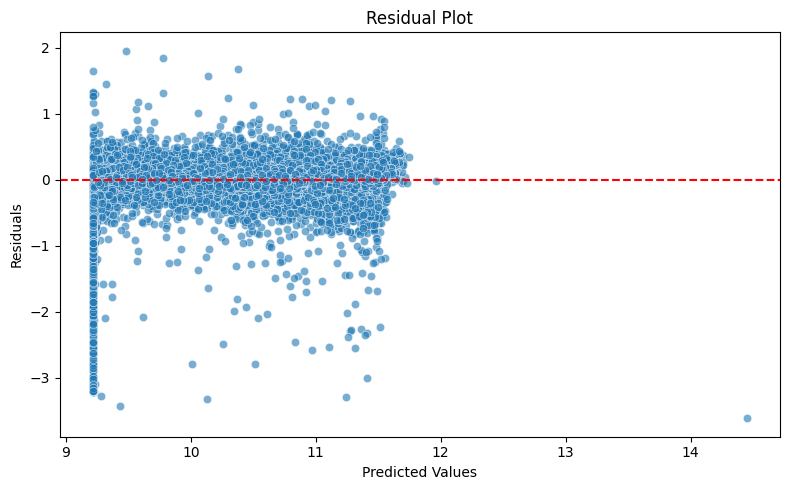

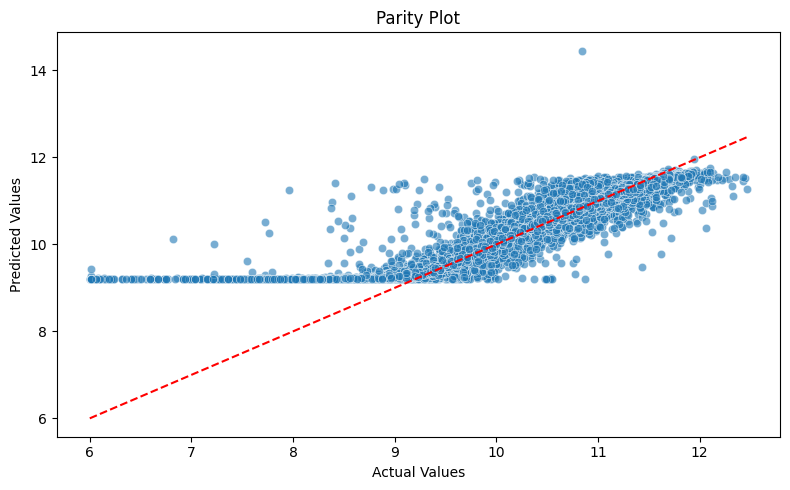

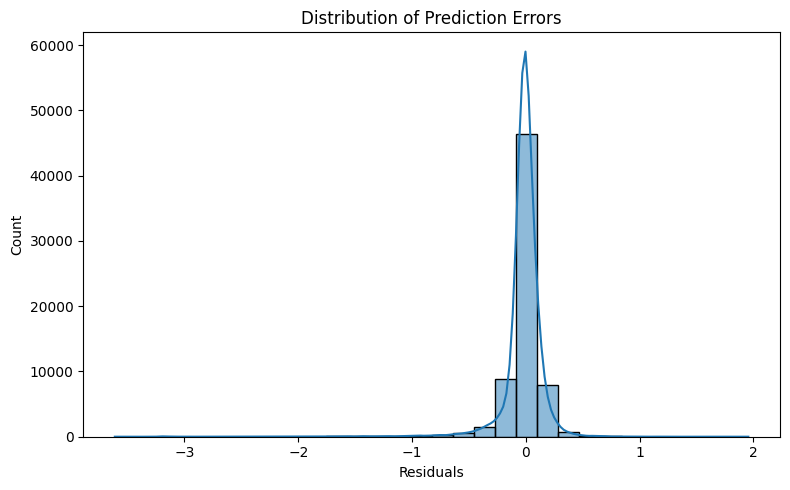

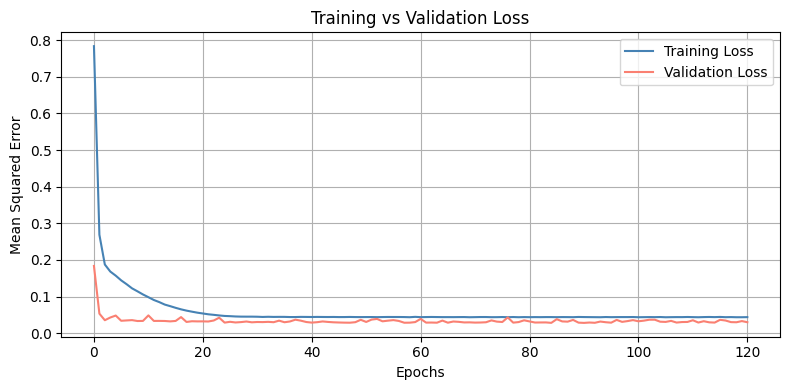

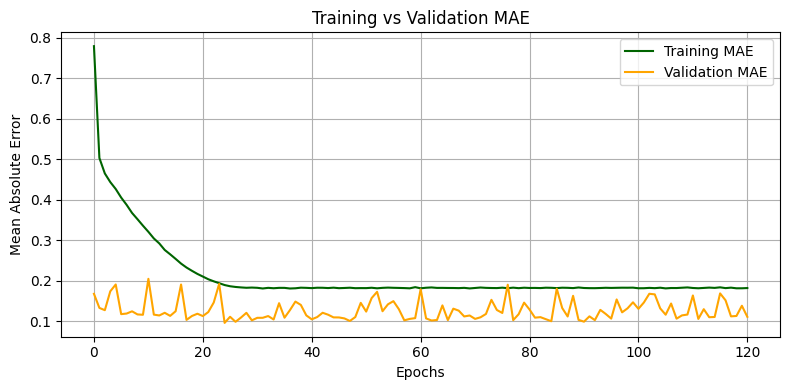

In [25]:
plot_visualizations(history, y_test, y_pred_full)

In [26]:
df_unseen = pd.read_csv(f"../data/processed/unseen_data.csv")

X_unseen = df_unseen[spectro_cols + photo_cols + generic_cols]
y_unseen = df_unseen[target_col]

In [27]:
X_unseen_scaled = scaler.transform(X_unseen)

In [28]:
y_pred_unseen = model.predict(X_unseen_scaled)

6980/6980 [==============================] - 10s 1ms/step


In [29]:
plot_metrics(y_unseen, y_pred_unseen)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.0995
Root Mean Squared Error (RMSE): 0.4037
R² Score: 0.6190


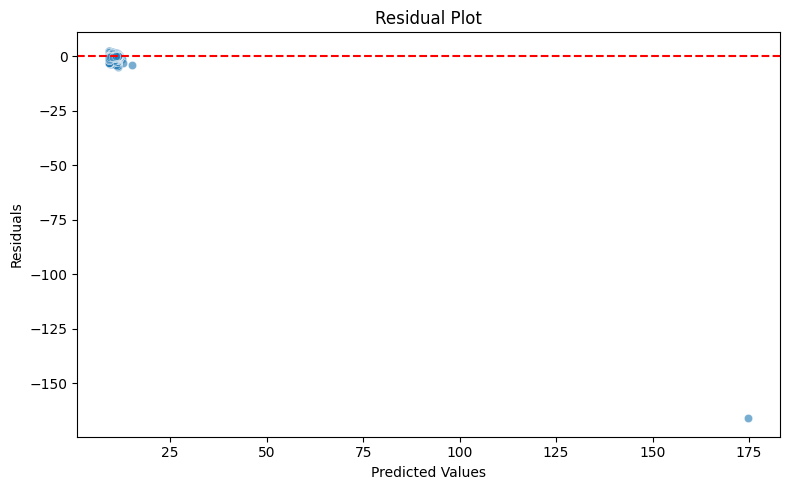

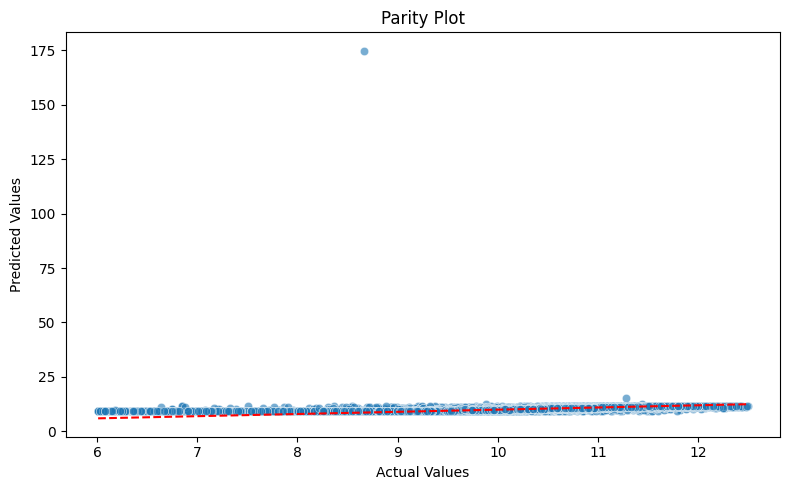

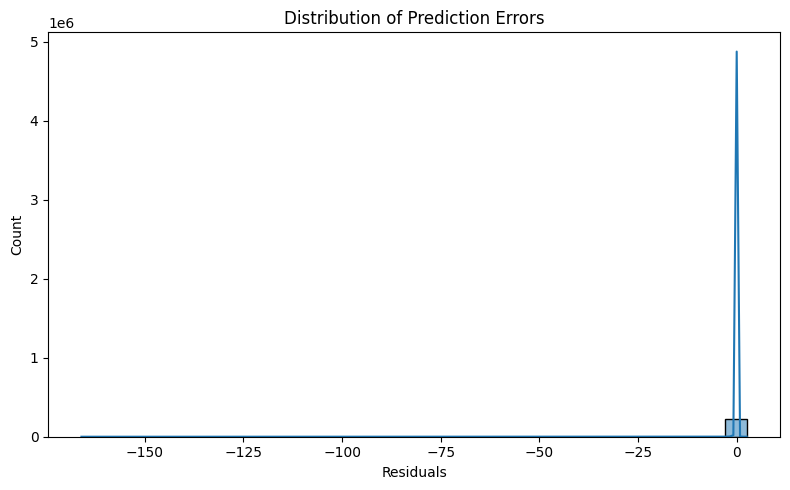

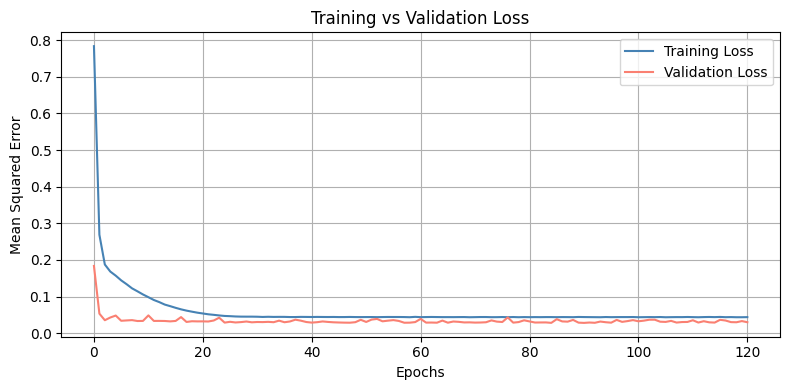

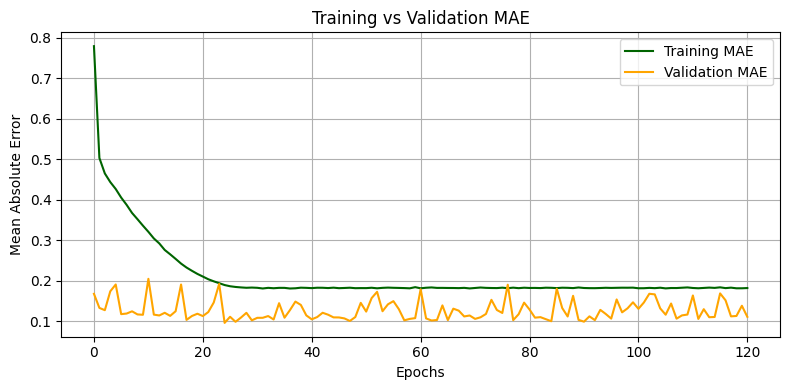

In [30]:
plot_visualizations(history, y_unseen, y_pred_unseen)